# Simple Genetic Algorithms

## Overview

Simple genetic algorithms work with a **coding of the parameter set**.

Given an initial random population, SGA uses 3 operators:

1. Reproduction
2. Crossover
3. Mutation


## Objective Functions

The following are the given test objective functions.


### De Jong's Function

(see http://www.geatbx.com/download/GEATbx_ObjFunExpl_v38.pdf page 3)

$$ f_1(x) = \sum_{i=1}^n x_i^2 \qquad -5.12 \leq x_i \leq 5.12 $$

### Rosenbrock's Valley

(see http://www.geatbx.com/download/GEATbx_ObjFunExpl_v38.pdf page 5)

$$ f_2(x) = \sum_{i=1}^{n-1} 100 \cdot (x_{i+1} - x_i^2)^2 + (1-x_i)^2  \qquad  -2.048 \leq x_i \leq 2.048 $$

### Himmelblau's Function

(see https://en.wikipedia.org/wiki/Himmelblau%27s_function)

$$ f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2 $$

In [1]:
# Converts binary string to integer and squares it
squared_OF = lambda x: int(x, 2) ** 2


def dejong_OF(coding):
    # from the coding, get a list of real numbers [x...], where -5.12 ≤ x ≤ 5.12
    n = 4
    bits_list = [coding[i:i+n] for i in range(0, len(coding), n)]
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    xlist = [sign * (num % 5.12) for sign, num in signs_nums]
    return sum(x**2 for x in xlist)


def rosenbrock_OF(coding):
    n = 3
    bits_list = [coding[i:i+n] for i in range(0, len(coding), n)]
    signs_nums = [(-1 if bits[0] == '0' else 1, int(bits[1:], 2)) for bits in bits_list]
    x = [sign * (num % 2.048) for sign, num in signs_nums]
    irange = range(len(x)-1)
    terms = (100 * (x[i+1] - x[i]**2)**2 + (1-x[i])**2 for i in irange)
    return sum(terms)
    

def himmelblau_OF(coding):
    pass


def ESF_OF(coding):
    '''
    Coding defines a sequence of {-1, 1}
    Objective is to find a sequence that yields a result of 0
    '''
    a = [0] + [-1 if bit == '0' else 1 for bit in coding]
    return 10 - abs(
        a[1]*a[2] + a[1]*a[3] + a[1]*a[4] + a[1]*a[5] +
        a[2]*a[3] + a[2]*a[4] + a[2]*a[5] + a[3]*a[4] +
        a[3]*a[5] + a[4]*a[5]
    )

Imports for plotting.

In [2]:
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## SGA Implementation

First we need utilities to generate the random strings that SGA operates on.

In [3]:
import random
from typing import Callable, List


def random_string(length: int) -> str:
    """
    :param length: [int] length of random string
    :returns: [string] random string consisting of "0" and "1"
    """
    return ''.join('0' if random.random() > 0.5 else '1' for _ in range(length))
    

def generate_sample_population(number=4, length=5) -> List:
    """
    :param number: [default=4] number of strings to return
    :param length: [default=5] length of the strings to return
    :returns: a random list of binary strings
    """
    return [random_string(length) for _ in range(number)]

In [4]:
MIN = 0
MAX = 1


def reproduction(population: List, fitness_func: Callable, min_or_max=MAX) -> List:
    """
    Produces a new population from biased roulette reproduction of the given population.
    """
    # First, we define the probability density (roulette weights) for each
    # member in our given population.
    all_fitness = [fitness_func(m) for m in population]
    total_fitness = sum(all_fitness)
    min_fitness = min(all_fitness)
    
    def compute_weight(m):
        """
        Subroutine which computes the weight of the biased roulette, which 
        is agnostic of the fitness function. In particular, it will invert
        the fitness value if we are seeking a minimum.
        """
        fitness = fitness_func(m)
        if min_or_max == MAX:
            return (fitness - min_fitness) + 1
        elif min_or_max == MIN:
            return 1/(fitness+1)
    
    # Here we normalize the weights to be proportions of the total weighting
    weights = [(compute_weight(m), m) for m in population]
    total_weights = sum(w for w, m in weights)
    pdf = [(w/total_weights, m) for w, m in weights]
    
    # Now we pick members for the new population.
    # We pick the same number of members as the provided population.
    new_population = []
    for i in range(len(population)):
        rand = random.random()
        cumul = 0
        for end_interval, member in pdf:
            cumul += end_interval
            if rand <= cumul:
                new_population.append(member)
                break
    
    return new_population

In [5]:
def crossover(string1, string2, index):
    head1, tail1 = string1[:index], string1[index:]
    head2, tail2 = string2[:index], string2[index:]
    return head1+tail2, head2+tail1

def mutation(string, probability):
    flipped = lambda x: '1' if x is '0' else '0'
    chars = (flipped(c) if random.random() < probability else c for c in string)
    return ''.join(chars)

In [6]:
def population_crossover(population, probability):
    pairs = []
    new_population = []
    while len(population) > 1:
        pairs.append((population.pop(), population.pop()))
    if len(population) == 1:
        new_population.append(population.pop())
        
    for s1, s2 in pairs:
        if random.random() < probability: 
            # don't perform crossover, just add the original pair
            new_population += [s1, s2]
            continue
        idx = random.randint(1, len(s1)-1) # select crossover index
        new_s1, new_s2 = crossover(s1, s2, idx)
        new_population.append(new_s1)
        new_population.append(new_s2)
    return new_population

def mutate_population(population, prob):
    return [mutation(m, prob) for m in population]

Global optimum: 10110110110110110111 with OF = 0.0


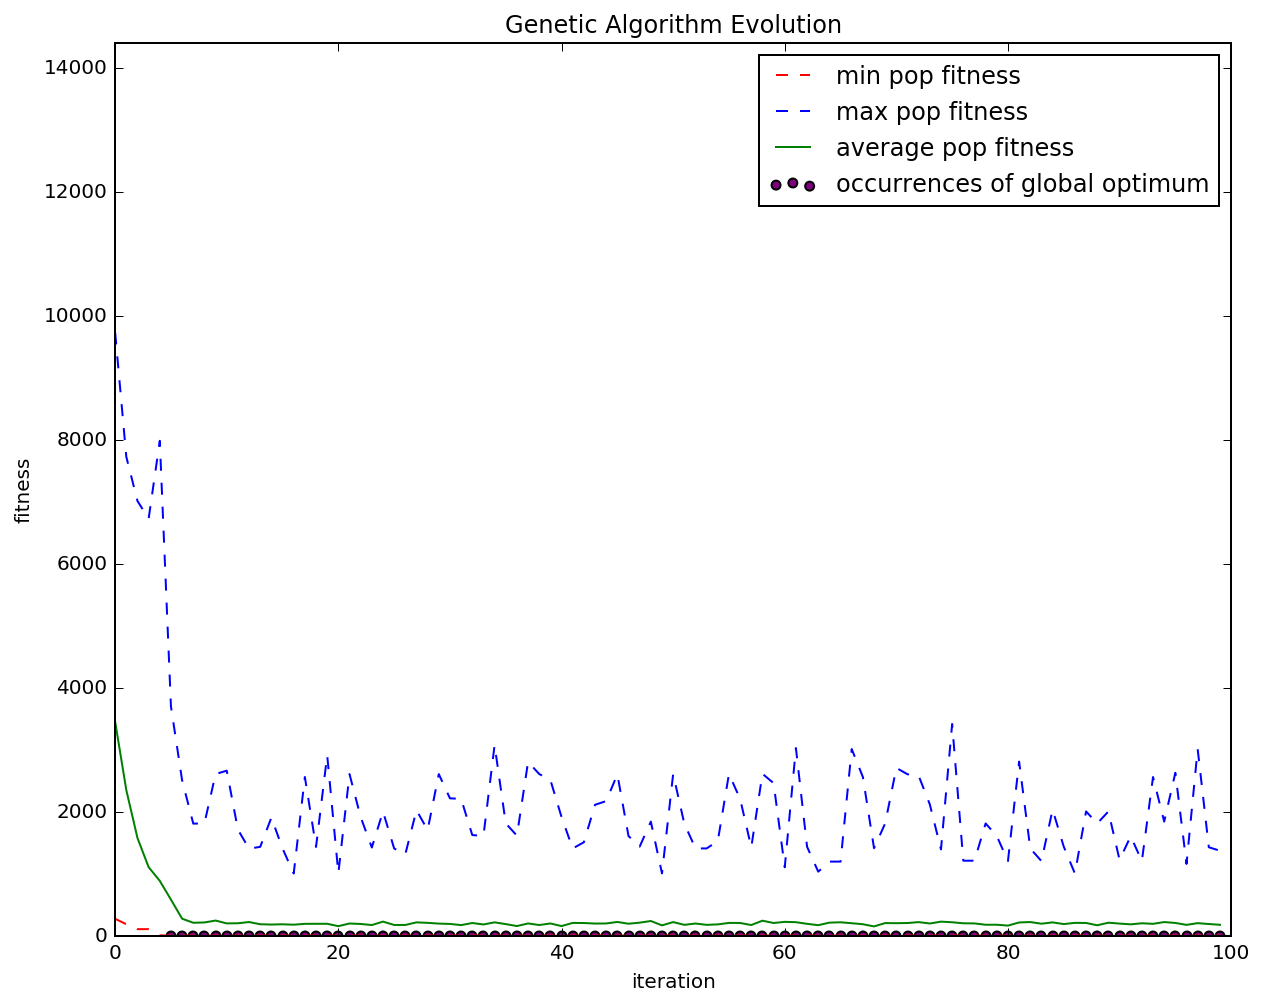

In [8]:
# Define fitness function and probabilistic parameters
fitness = rosenbrock_OF
min_or_max = MIN
crossover_probability = 0.3
mutation_probability = 0.05
NUM_ERAS = 100

# Initialize population
population = generate_sample_population(number=200, length=20)
populations = []
    
# Perform NUM_ERAS of evolution
for i in range(NUM_ERAS):
    populations.append(population)
    population = reproduction(population, fitness, min_or_max)
    population = population_crossover(population, crossover_probability)
    population = mutate_population(population, mutation_probability)


# The GA execution is done.
# This is stuff for plotting
x_axis = range(len(populations))
fitnesses = [[fitness(m) for m in population] for population in populations]
mins = [min(f) for f in fitnesses]
maxs = [max(f) for f in fitnesses]
avgs = [sum(f)/len(f) for f in fitnesses]

# Find the "global optimum" of all the chromosomes we looked at.
# A better term for this chromosome is "best individual".
all_chromosomes = (c for pop in populations for c in pop)
optimizer = min if min_or_max == MIN else max
global_optimum = optimizer(all_chromosomes, key=fitness)

optima = [(it, fitness(global_optimum)) for it, pop in enumerate(populations) if global_optimum in pop]
x_optima = [x[0] for x in optima]
y_optima = [x[1] for x in optima]
line_mins, line_maxs, line_avgs = plt.plot(x_axis, mins, 'r--', maxs, 'b--', avgs, 'g-')
scatter_ceil = plt.scatter(x_optima, y_optima, c='purple')
ymin, ymax = plt.ylim()
plt.ylim(0, round(ymax*1.20))
#xmin, xmax = plt.xlim()
plt.xlim(0, NUM_ERAS)
plt.legend(
    (line_mins, line_maxs, line_avgs, scatter_ceil), 
    ("min pop fitness", "max pop fitness", "average pop fitness", "occurrences of global optimum"), 
    loc="upper right"
)
plt.title("Genetic Algorithm Evolution")
plt.xlabel('iteration')
plt.ylabel('fitness')

print("Global optimum: {} with OF = {}".format(global_optimum, fitness(global_optimum)))